In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import coffea.hist as hist
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams.update({'font.size': 16})
import scipy
import math
import numba
import bitstruct as bitstruct

In [2]:
def getDataRawOld(fname):
    data = []
    format=bitstruct.compile("p4u12u12u12u12u12"*(256*int(30/5)))
    swapformat="8"*(256*int(30/5))
    with open(fname, "rb") as f:
        line = f.read((1+4+int(256*30/5))*8)
        while len(line) == (1+4+int(256*30/5))*8:
            data.extend(format.unpack(bitstruct.byteswap(swapformat, line[5*8:])))
            line = f.read((1+4+int(256*30/5))*8)
    data = np.array(data)
    return data.reshape([-1, 30, 256])

def getDataRaw(fnames):
    N64BWORDS = 1440
    #N64BWORDS = 1536
    times_320 = []
    times = []
    data = []
    format_time320=bitstruct.compile("u64")
    format_time=bitstruct.compile("u64")
    format_header=bitstruct.compile("u16p48")
    format_accheader=bitstruct.compile("u56u8")
    format=bitstruct.compile("u12"*(256*30))
    #format=bitstruct.compile("p4u12u12u12u12u12"*(256*int(30/5)))
    swapformat="8"*(N64BWORDS)
    for fname in fnames:
        print(fname)
        with open(fname, "rb") as f:
            line = f.read((1+4+N64BWORDS)*8)
            lnum = 0
            while len(line) == (1+4+N64BWORDS)*8:
                acc_header = format_accheader.unpack(bitstruct.byteswap("8", line[0*8:1*8]))
                header = format_header.unpack(bitstruct.byteswap("8", line[1*8:2*8]))
                lnum += 1
                if acc_header[0] != 0x123456789abcde or header[0] != 0xac9c:
                    #print("CORRUPT EVENT!!! ", lnum, "%x"%acc_header[0], "%x"%header[0])
                    line = f.read((1+4+N64BWORDS)*8)
                    continue
                times_320.extend(format_time320.unpack(bitstruct.byteswap("8", line[2*8:3*8])))
                times.extend(format_time320.unpack(bitstruct.byteswap("8", line[3*8:4*8])))
                data.extend(format.unpack(bitstruct.byteswap(swapformat, line[5*8:])))
                line = f.read((1+4+N64BWORDS)*8)
    data = np.array(data)
    times = np.array(times)
    times_320 = np.array(times_320)
    return times_320.reshape([-1,]), times.reshape([-1,]), data.reshape([-1, 30, 256])

def getData(fnames):
    data = []
    for fname in fnames:
        with open(fname) as f:
            for line in f:
                data.extend(line.split()[1:31])
    data = np.array(data, dtype='float')
    return data.reshape([-1, 256, 30])    

In [3]:
ped_data = getDataRawOld("testData/cal_0812_2.txt")
time320data, time1data, data = getDataRaw(["testData/WR_5way_composite_600_20230514","testData/WR_5way_composite_700_20230514","testData/WR_5way_composite_800_20230514","testData/WR_5way_composite_900_20230514","testData/WR_5way_composite_1000_20230514"])#getData(["Data_20200312_030712.txt",])
sineData = data
true_freq = 250000000
averages = ped_data.mean(0)
stddevs = ped_data.std(0)
#sineData = getData(["Data_20200312_034047.txt", "Data_20200312_034055.txt"])

testData/WR_5way_composite_600_20230514
testData/WR_5way_composite_700_20230514
testData/WR_5way_composite_800_20230514
testData/WR_5way_composite_900_20230514
testData/WR_5way_composite_1000_20230514


In [137]:
#averages = np.zeros(ped_data.mean(0).shape)

#averages = averages.transpose()

In [15]:
def sine(x, A, B, omega, phi):
    return A * np.sin(omega*x + phi) + B
def wrap(x):
    return np.remainder(x+math.pi, 2*math.pi)-math.pi

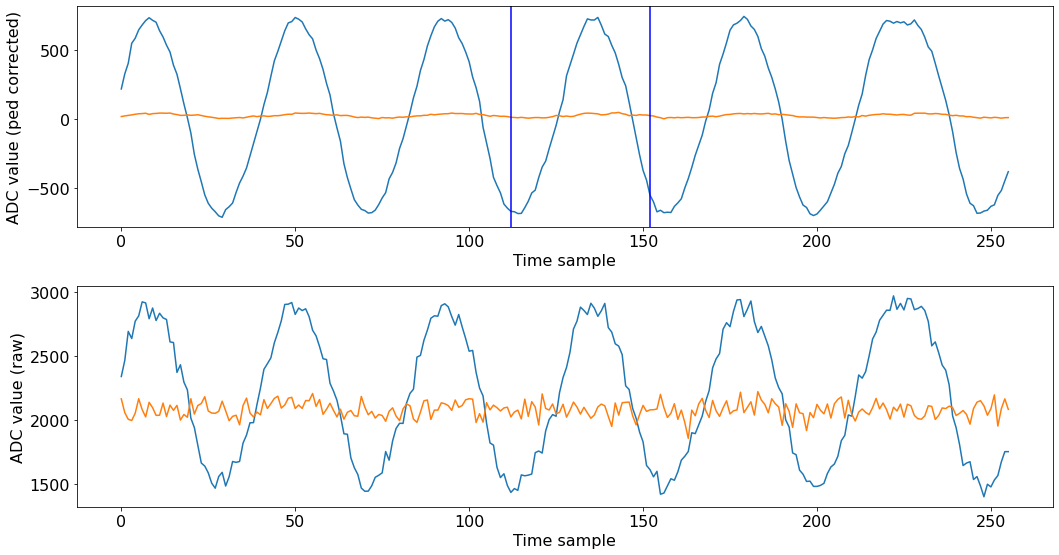

In [114]:
   
#channel_pulse = np.array([5,11,17,23,29])
#channel_pulse = np.array([3,24,])
#channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channel_pulse = np.array([11,12])
event = 100

xdata = np.linspace(0, 255,256)
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:]
cw_low = (((time320data[event]+3+1)%8)*32-16)%256
cw_high = (((time320data[event]+3+1)%8)*32+24)%256

#popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/5, 0.0))
#popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:200], ydata[0:200], p0=popt)
#print(*popt)

fig, (ax1, ax2) = plt.subplots(2, 1)

#plt.plot(data[1,channel,2:]-data[1,channel,2:].mean())
#plt.plot(xdata, ydata_raw, label="data")
#ax1.plot(xdata, ydata, label="250 MHz sine")
#ax1.plot(xdata, sine(xdata, *popt), label="sine fit")
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="Pulse %i"%i)
#ax1.legend(loc="lower right")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")
ax1.axvline(cw_high, color="blue")
ax1.axvline(cw_low, color="blue")

#ax2.plot(xdata, ydata_raw, label="250 MHz sine")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")
fig.tight_layout()



In [73]:
nevents = 1000
for e in range(0,nevents):
    pulse = sineData[e,:,:]
    max = 0
    for iCap in range(256):
        #Find the most indifferentiable point of the pulse, window of 5 samples.
            cap0 = (iCap+254)%256
            cap1 = iCap
            cap2 = (iCap+2)%256
            diff01 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[11, cap1]+pulse[11, cap0])
            diff02 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[17, cap1]+pulse[17, cap0])
            diff03 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[23, cap1]+pulse[23, cap0])
            diff04 = np.abs(pulse[11, cap1] - pulse[11, cap0]-pulse[29, cap1]+pulse[29, cap0])
            diff11 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[11, cap2]+pulse[11, cap1])
            diff12 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[17, cap2]+pulse[17, cap1])
            diff13 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[23, cap2]+pulse[23, cap1])
            diff14 = np.abs(pulse[11, cap2] - pulse[11, cap1]-pulse[29, cap2]+pulse[29, cap1])
            diffsum  = diff01+diff02+diff03+diff04+diff11+diff12+diff13+diff14
            if max <diffsum:
                max = diffsum
                trigger_pos[e] = cap1 

256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840


Text(0, 0.5, 'measured ADC')

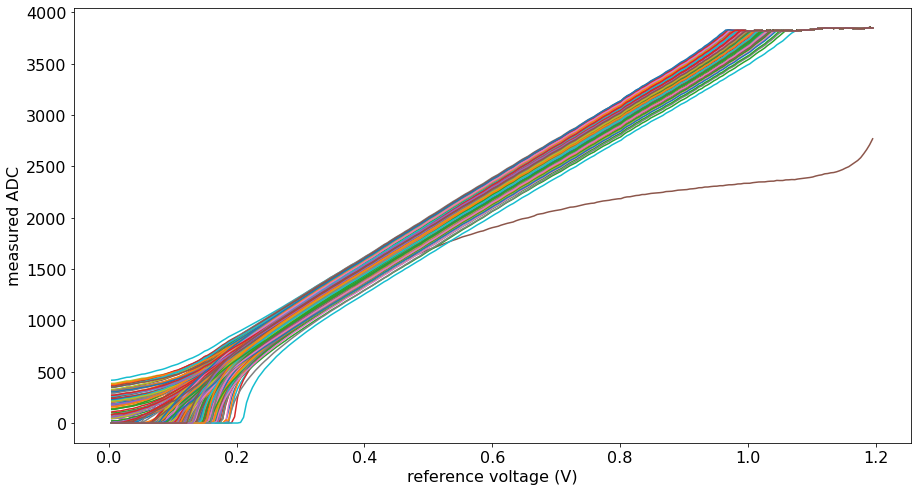

In [5]:
means = []
x_vals = [i for i in range(0x10, 0xfff, 0x10)]
for i in x_vals:
    if i % 0x100 == 0: print(i)
    pedData = getDataRawOld("configs/0/scan_pedestals_%i"%i)
    means.append(pedData.mean(0))
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

channel = 3

for i in range(256):
    meanList = np.array([mean[channel,i] for mean in means])
    plt.plot(refVoltage, meanList)
    
plt.xlabel("reference voltage (V)")
plt.ylabel("measured ADC")

In [6]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except(ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [30]:
data = getDataRaw("testData/EJ_awg_tri10_scan")#getData(["Data_20200312_030712.txt",])
data2 = getDataRaw("testData/EJ_awg_tri20_scan")
data3 = getDataRaw("testData/EJ_awg_tri40_scan")
data4 = getDataRaw("testData/EJ_awg_tri60_scan")
data5 = getDataRaw("testData/EJ_awg_tri80_scan")
data6 = getDataRaw("testData/EJ_awg_tri120_scan")


In [7]:
import scipy.interpolate
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])
        
voltageLin = []
for j in range(0, 30):
    voltageLin.append([])
    for i in range(0, 256):
        meanList = np.array([mean[j,i] for mean in means])
        meanList = savitzky_golay(meanList, 41, 2)
        voltageLin[j].append(scipy.interpolate.interp1d(meanList, refVoltage, bounds_error=False, fill_value=(0, 1.2)))
        
xv = np.array([acd for acd in range(4096)])
yv = voltageLin[0][0](xv)

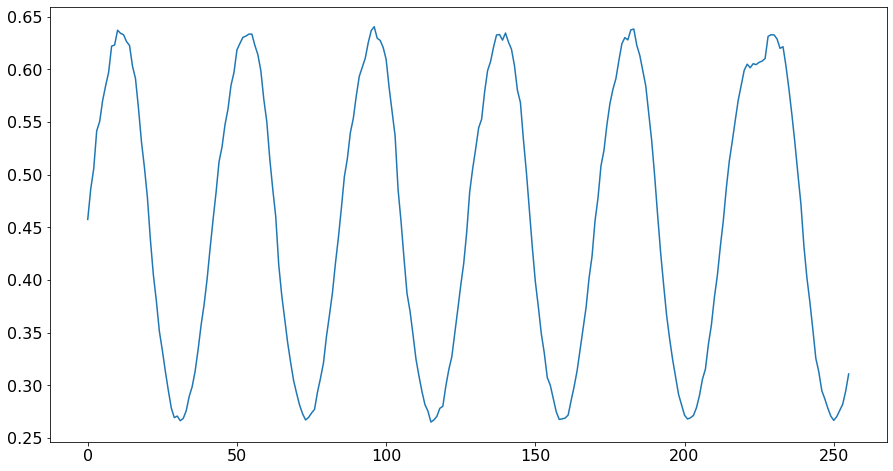

In [8]:
sineData = data
linDat = np.zeros_like(sineData, float)
for j in range(0, 30):
    for i in range(0, 256):
        linDat[:,j,i] = voltageLin[j][i](sineData[:,j,i])
xdata = np.linspace(0, 255,256)
plt.plot(xdata, linDat[156,11,:])
true_freq = 250000000
ped_value=0x800
nevents = 1000

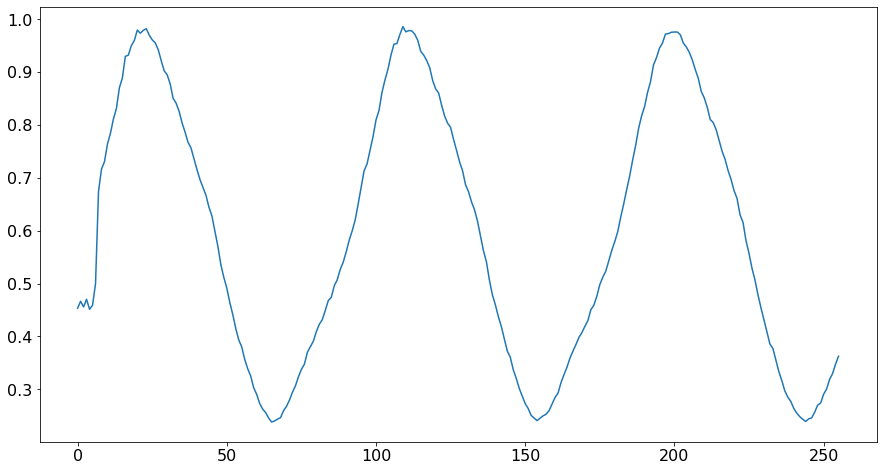

In [100]:
sineData = np.concatenate((data2, data3, data4, data5, data6), axis=0)#[3000:4000]
linDat = np.zeros_like(sineData, float)
for j in range(0, 30):
    for i in range(0, 256):
        linDat[:,j,i] = voltageLin[j][i](sineData[:,j,i])
xdata = np.linspace(0, 255,256)
plt.plot(xdata, linDat[4056,11,:])
true_freq = 250000000
ped_value=0x800
nevents = 5000

In [101]:
import scipy.stats
#ydata = sineData-averages
ydata = linDat - 1.2/4096*ped_value
ydata2 = np.concatenate((ydata, ydata, ydata), axis=2)
def reject_outliers(data):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    return d/mdev if mdev else 0.
def reject_inliers(data1, data2):
    d1 = np.abs(data1 - np.median(data1))
    d2 = np.abs(data2 - np.median(data2))
    mdev1 = np.median(d1)
    mdev2 = np.median(d2)
    return np.sqrt((d1/mdev1)**2+(d2/mdev2)**2) if mdev1 and mdev2 else 0.
    
timeOffsets = np.zeros((30, 256))
out_cutoff = 3
in_cutoff = 0.8
for channel in [11]:
    chTimeOffsetMatrix = []
    x = []
    y =[]
    coefs = []
    for iCap in range(256):
        
        cap1 = iCap+256-4
        cap2 = iCap+256+4
        tmpx = []
        tmpy = []
        for e in range(0,nevents):
            res = scipy.stats.linregress(range(cap1, cap2), ydata2[e,channel,cap1:cap2])
            if((res.rvalue>0.8 or res.rvalue<-0.8) and np.abs(np.average(ydata2[e,channel,cap1:cap2]))<0.3):
                tmpx.append(np.average(ydata2[e,channel,cap1:cap2]))
                tmpy.append(res.slope)
        
        tmpx = np.array(tmpx)
        tmpy = np.array(tmpy)
        #tmpx = tmpx[reject_outliers(tmpy)<out_cutoff]
        #tmpy = tmpy[reject_outliers(tmpy)<out_cutoff]

        x.append(tmpx)
        y.append(tmpy)
        #y = y[(x > 1200) | (x < -1200)]
        #x = x[(x > 1200) | (x < -1200)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]
        # Formulate and solve the least squares problem ||Ax - b ||^2
        
        A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
        b = np.ones_like(x[iCap])
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        coefs.append(fit)
        #print(fit)

        try:  
            a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("a = %f"%a)
            b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("b = %f"%b)

            dtij = math.atan(b/a)/(math.pi*true_freq)
            #print("dtij = %f ps"%(dtij*1e12))
            chTimeOffsetMatrix.append(dtij)
        except:
            chTimeOffsetMatrix.append(100.0e-12)
    timeOffsets[channel] = np.array(chTimeOffsetMatrix)
    



Text(0.5, 0, 'timesample')

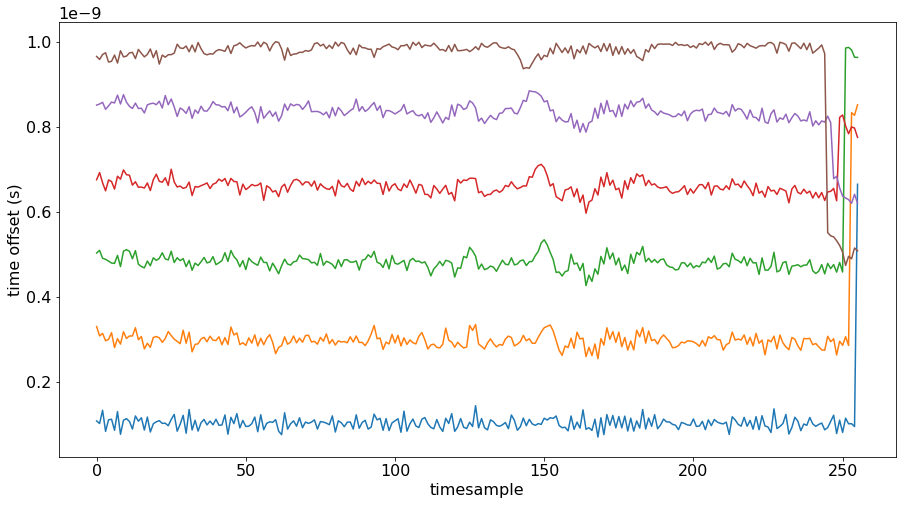

In [42]:
import scipy.stats
#ydata = sineData-averages
ydata = linDat - 1.2/4096*ped_value
ydata2 = np.concatenate((ydata, ydata, ydata), axis=2)
def reject_outliers(data):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    return d/mdev if mdev else 0.
def reject_inliers(data1, data2):
    d1 = np.abs(data1 - np.median(data1))
    d2 = np.abs(data2 - np.median(data2))
    mdev1 = np.median(d1)
    mdev2 = np.median(d2)
    return np.sqrt((d1/mdev1)**2+(d2/mdev2)**2) if mdev1 and mdev2 else 0.
    
timeOffsets = np.zeros((30 ,30, 256))
timeOffsetSum = np.zeros((30, 30 ,256))
timeOffsetVar = np.zeros((30, 30 ,256))
nevents = 1000
out_cutoff = 3
in_cutoff = 0.8
for diff in [1, 3, 5, 7, 9, 11]:
    for channel in [11]:
        chTimeOffsetMatrix = []
        chTimeVarMatrix = []
        x = []
        y =[]
        coefs = []
        for iCap in range(256):
            
            cap1 = iCap+256
            cap2 = iCap+256+diff
            x.append(ydata2[:,channel, cap2] + ydata2[:,channel, cap1])
            y.append(ydata2[:,channel, cap1] - ydata2[:,channel, cap2])
            # Formulate and solve the least squares problem ||Ax - b ||^2
            
            A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
            b = np.ones_like(x[iCap])
            fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
            res = np.linalg.lstsq(A, b, rcond=None)[1]
            coefs.append(fit)
            #print(fit)

            try:  
                a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                #print("a = %f"%a)
                b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                #print("b = %f"%b)

                dtij = math.atan(b/a)/(math.pi*true_freq)
                #print("dtij = %f ps"%(dtij*1e12))
                chTimeOffsetMatrix.append(dtij)
                
            except:
                chTimeOffsetMatrix.append(100.0e-12)
            chTimeVarMatrix.append(res)
        arr = np.zeros((256,256))
        for i in range(256):
            for j in range(256):
                if(j-i>=0 and j-i<diff):
                    arr[i,j] = 1
                if(j-i<0 and j-i+256<diff):
                    arr[i,j] = 1
        
        timeOffsets[diff, channel] = np.dot(np.linalg.inv(arr),np.array(chTimeOffsetMatrix))
        plt.plot(chTimeOffsetMatrix, label="diff = %d"%diff)
        
        for i in range(256):
            timeOffsetSum[diff, channel, i] =  np.sum(timeOffsets[diff, channel, 0:i])
            timeOffsetVar[diff, channel, i] =  chTimeVarMatrix[i]
        
    #plt.step(np.linspace(0, 255, 256), timeOffsetSum[diff,channel])
    
plt.ylabel("time offset (s)")
plt.xlabel("timesample")



[8.83851106e-11 9.37849725e-11 1.15015271e-10 8.37375216e-11
 1.09339617e-10 1.10690021e-10 7.97901505e-11 1.19859608e-10
 7.32784780e-11 1.02049153e-10 1.06691823e-10 9.47447974e-11
 8.18250666e-11 1.09671701e-10 1.06228632e-10 1.13581213e-10
 8.89310988e-11 1.11842068e-10 7.80254410e-11 9.20838939e-11
 1.00363418e-10 9.85030799e-11 9.37805675e-11 9.81980208e-11
 9.20078710e-11 1.07062386e-10 1.18349621e-10 8.10404298e-11
 9.49523961e-11 1.08462252e-10 7.68309732e-11 1.30115974e-10
 7.99026116e-11 1.01574651e-10 8.04513782e-11 9.60911386e-11
 1.04256245e-10 9.06036708e-11 1.02168456e-10 9.35643914e-11
 1.04533457e-10 8.86980693e-11 8.65960560e-11 1.13310740e-10
 7.26310866e-11 1.09962004e-10 1.00125061e-10 1.14724472e-10
 8.42947199e-11 1.02452368e-10 9.03565350e-11 9.36091819e-11
 1.00132971e-10 1.10400299e-10 7.39550611e-11 1.16673873e-10
 8.22408153e-11 9.75900413e-11 1.03602245e-10 1.00659403e-10
 1.04765542e-10 7.92554096e-11 7.10886585e-11 1.19531907e-10
 8.56559768e-11 9.461288

Text(0.5, 0, 'timesample')

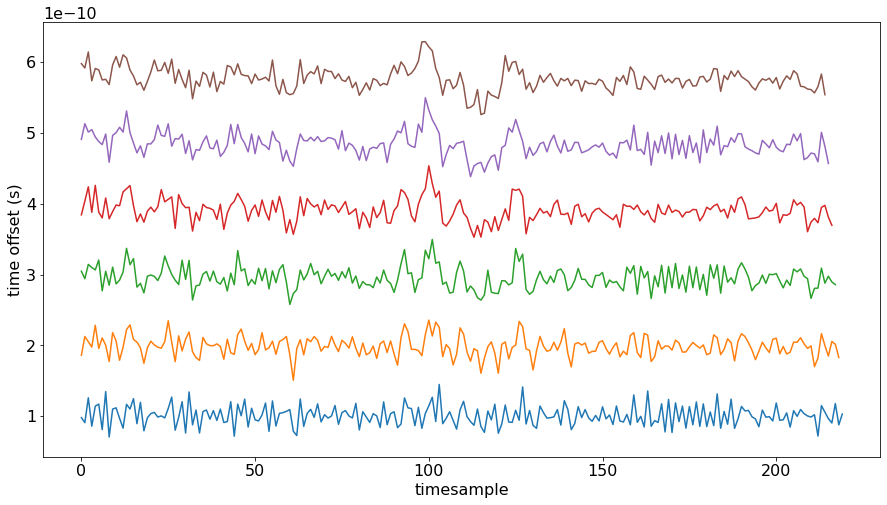

In [129]:

#Weighted least squares fit

import scipy.stats
#ydata = sineData-averages
ydata = linDat - 1.2/4096*ped_value
ydata2 = np.concatenate((ydata, ydata, ydata), axis=2)
def reject_outliers(data):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    return d/mdev if mdev else 0.
def reject_inliers(data1, data2):
    d1 = np.abs(data1 - np.median(data1))
    d2 = np.abs(data2 - np.median(data2))
    mdev1 = np.median(d1)
    mdev2 = np.median(d2)
    return np.sqrt((d1/mdev1)**2+(d2/mdev2)**2) if mdev1 and mdev2 else 0.
    

timeOffsetWeightedSum = np.zeros((30 ,256))
timeOffsetWeightedVar = np.zeros((30 ,256))
a_matrix = []
y_matrix = []
w_matrix = []
nevents = 1000
out_cutoff = 3
in_cutoff = 0.8
for diff in [1, 2, 3, 4, 5, 6]:
    for channel in [11]:
        chTimeOffsetMatrix = []
        chTimeVarMatrix = []
        x = []
        y =[]
        coefs = []
        for iCap in range(256):
            
            cap1 = iCap+256
            cap2 = iCap+256+diff
            if(diff>1 and iCap+diff>255):continue
            x.append(ydata2[:,channel, cap2] + ydata2[:,channel, cap1])
            y.append(ydata2[:,channel, cap1] - ydata2[:,channel, cap2])
            # Formulate and solve the least squares problem ||Ax - b ||^2
            
            A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
            b = np.ones_like(x[iCap])
            fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
            res = np.linalg.lstsq(A, b, rcond=None)[1]
            coefs.append(fit)
            #print(fit)

            try:  
                a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                #print("a = %f"%a)
                b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                #print("b = %f"%b)

                dtij = math.atan(b/a)/(math.pi*true_freq)
                #print("dtij = %f ps"%(dtij*1e12))
                chTimeOffsetMatrix.append(dtij)
                
            except:
                chTimeOffsetMatrix.append(100.0e-12)
            chTimeVarMatrix.append(res)
        vsize = 256-diff
        if(diff==1):vsize = 256
        arr = np.zeros((vsize,256))
        for i in range(vsize):
            for j in range(256):#Do not include wraparound terms for diff>1
                if(j-i>=0 and j-i<diff):
                    arr[i,j] = 1
        a_matrix.append(arr)
        y_matrix.append(np.array(chTimeOffsetMatrix))
        w_matrix.append(np.array(chTimeVarMatrix))
        plt.plot(chTimeOffsetMatrix, label="diff = %d"%diff)

#print(np.divide(np.concatenate(a_matrix, axis=0),np.concatenate(w_matrix, axis=0)))
#print(np.concatenate(y_matrix, axis=None))
#print(np.divide(np.concatenate(y_matrix, axis=None),np.concatenate(w_matrix, axis=0).squeeze()))   
#print(np.concatenate(w_matrix, axis=0))   
timeOffsetWeighted = np.linalg.lstsq(np.divide(np.concatenate(a_matrix, axis=0),np.concatenate(w_matrix, axis=0)), np.divide(np.concatenate(y_matrix, axis=None),np.concatenate(w_matrix, axis=0).squeeze()), rcond=None)[0].squeeze()
print(timeOffsetWeighted)
        
    #plt.step(np.linspace(0, 255, 256), timeOffsetSum[diff,channel])
    
plt.ylabel("time offset (s)")
plt.xlabel("timesample")



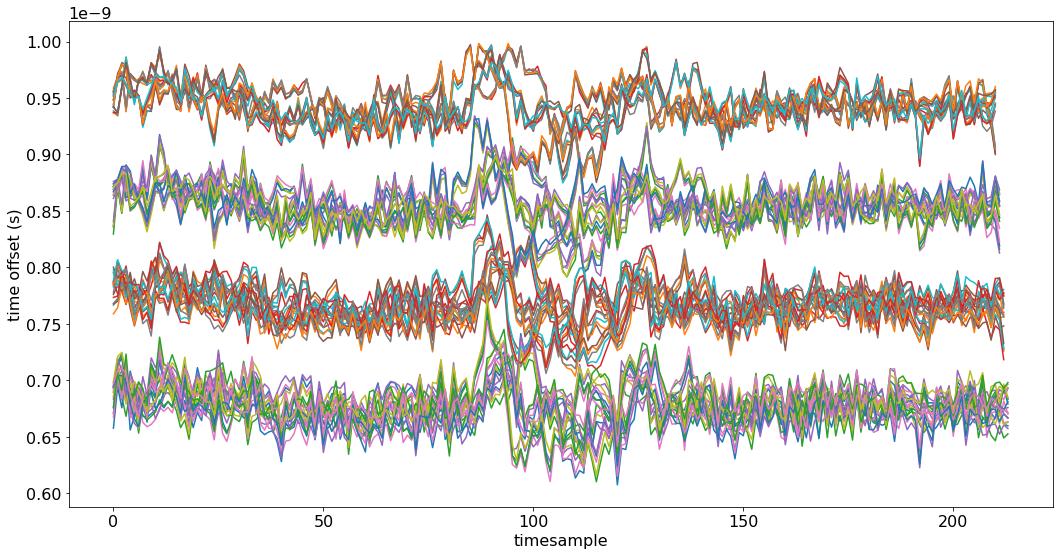

In [51]:

#Weighted least squares fit
#Fixed trigger position at 224
#For various pedestal values
TRIG_POS = 221


timeOffsetWeightedSum = np.zeros((30 ,256))
timeOffsetWeightedVar = np.zeros((30 ,256))
timeOffsetWeighted = np.zeros((30, 15 ,TRIG_POS-1))
timeOffsetSimple = np.zeros((30, 15 ,TRIG_POS-1))
a_matrix = []
y_matrix = []
w_matrix = []
nevents = 1000
out_cutoff = 3
in_cutoff = 0.8
for ped in [6,7,8,9,10]:
    ydata = linDat[(ped-6)*1000:(ped-5)*1000] - 1.2/16*ped
    for channel in [11, 17, 23, 29]:
        for diff in [7, 8, 9, 10]:
            chTimeOffsetMatrix = []
            chTimeVarMatrix = []
            x = []
            y =[]
            coefs = []
            for iCap in range(TRIG_POS - diff):
                
                cap1 = iCap
                cap2 = iCap+diff
                if(diff>1 and iCap+diff>255):continue
                x.append(ydata[:,channel, cap2] + ydata[:,channel, cap1])
                y.append(ydata[:,channel, cap1] - ydata[:,channel, cap2])
                # Formulate and solve the least squares problem ||Ax - b ||^2
                
                A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
                b = np.ones_like(x[iCap])
                fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
                res = np.linalg.lstsq(A, b, rcond=None)[1]
                coefs.append(fit)
                #print(fit)

                try:  
                    a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                    #print("a = %f"%a)
                    b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                    #print("b = %f"%b)

                    dtij = math.atan(b/a)/(math.pi*true_freq)
                    #print("dtij = %f ps"%(dtij*1e12))
                    chTimeOffsetMatrix.append(dtij)
                    
                except:
                    chTimeOffsetMatrix.append(100.0e-12)
                chTimeVarMatrix.append(res)
            if(diff==1):timeOffsetSimple[channel, ped] = np.array(chTimeOffsetMatrix)
            arr = np.zeros((TRIG_POS-diff,TRIG_POS-1))
            for i in range(TRIG_POS-diff):
                for j in range(TRIG_POS-1):#Do not include wraparound terms for diff>1
                    if(j-i>=0 and j-i<diff):
                        arr[i,j] = 1
            a_matrix.append(arr)
            y_matrix.append(np.array(chTimeOffsetMatrix))
            w_matrix.append(np.array(chTimeVarMatrix))
            plt.plot(chTimeOffsetMatrix, label="diff = %d"%diff)
        timeOffsetWeighted[channel, ped] = np.linalg.lstsq(np.divide(np.concatenate(a_matrix, axis=0),np.concatenate(w_matrix, axis=0)), np.divide(np.concatenate(y_matrix, axis=None),np.concatenate(w_matrix, axis=0).squeeze()), rcond=None)[0].squeeze()
    
plt.ylabel("time offset (s)")
plt.xlabel("timesample")
plt.tight_layout()


[9.83711600e-11 1.02093813e-10 1.18913873e-10 7.86746426e-11
 1.04592393e-10 1.04877334e-10 8.15701157e-11 1.15471617e-10
 7.44752760e-11 9.97745180e-11 1.06631382e-10 1.01240771e-10
 8.64834440e-11 1.12073852e-10 1.01199223e-10 1.04218377e-10
 8.39420857e-11 1.07656776e-10 7.80860037e-11 9.51557944e-11
 1.00960995e-10 1.00677959e-10 9.62803148e-11 9.81000526e-11
 8.84785285e-11 1.04805731e-10 1.14281276e-10 8.28408734e-11
 9.49923124e-11 1.08312226e-10 7.69802266e-11 1.27329652e-10
 7.71434530e-11 1.00943792e-10 8.53641047e-11 9.27818336e-11
 1.04837407e-10 9.09445274e-11 9.87061809e-11 9.37941081e-11
 1.02171206e-10 9.31558851e-11 9.18567313e-11 1.11786375e-10
 7.42871633e-11 1.06217488e-10 9.82727992e-11 1.13991134e-10
 8.85754331e-11 1.01586240e-10 8.90270018e-11 9.20847247e-11
 9.67511399e-11 1.06750151e-10 7.77236397e-11 1.16249416e-10
 8.27864218e-11 9.38840753e-11 1.00923722e-10 9.82681134e-11
 1.05025578e-10 8.16207563e-11 7.29972547e-11 1.20311685e-10
 8.57714717e-11 9.214767

Text(0.5, 0, 'timesample')

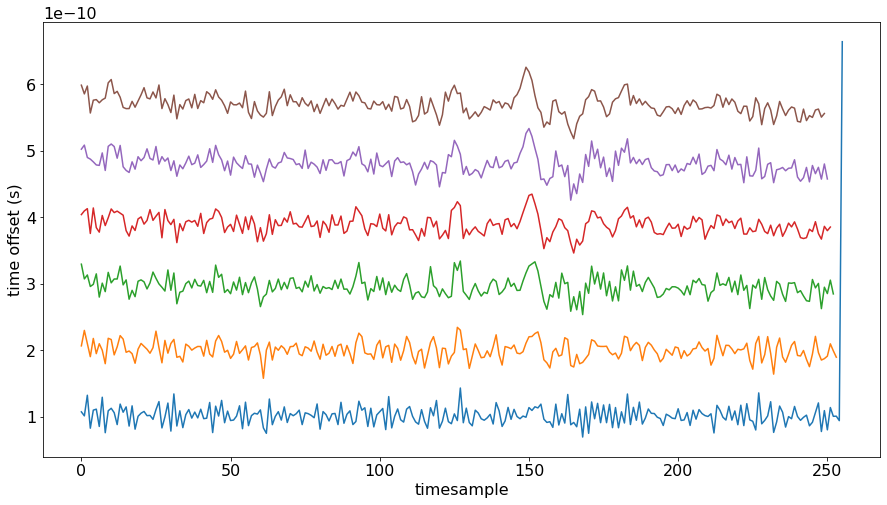

In [87]:

#Weighted least squares fit

import scipy.stats
#ydata = sineData-averages
ydata = linDat - 1.2/4096*ped_value
ydata2 = np.concatenate((ydata, ydata, ydata), axis=2)
def reject_outliers(data):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    return d/mdev if mdev else 0.
def reject_inliers(data1, data2):
    d1 = np.abs(data1 - np.median(data1))
    d2 = np.abs(data2 - np.median(data2))
    mdev1 = np.median(d1)
    mdev2 = np.median(d2)
    return np.sqrt((d1/mdev1)**2+(d2/mdev2)**2) if mdev1 and mdev2 else 0.
    

timeOffsetWeightedSum = np.zeros((30 ,256))
timeOffsetWeightedVar = np.zeros((30 ,256))
a_matrix = []
y_matrix = []
w_matrix = []
nevents = 1000
out_cutoff = 3
in_cutoff = 0.8
for diff in [1, 2, 3, 4, 5, 6]:
    for channel in [11]:
        chTimeOffsetMatrix = []
        chTimeVarMatrix = []
        x = []
        y =[]
        coefs = []
        for iCap in range(256):
            
            cap1 = iCap+256
            cap2 = iCap+256+diff
            if(diff>1 and iCap+diff>255):continue
            x.append(ydata2[:,channel, cap2] + ydata2[:,channel, cap1])
            y.append(ydata2[:,channel, cap1] - ydata2[:,channel, cap2])
            # Formulate and solve the least squares problem ||Ax - b ||^2
            
            A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
            b = np.ones_like(x[iCap])
            fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
            res = np.linalg.lstsq(A, b, rcond=None)[1]
            coefs.append(fit)
            #print(fit)

            try:  
                a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                #print("a = %f"%a)
                b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
                #print("b = %f"%b)

                dtij = math.atan(b/a)/(math.pi*true_freq)
                #print("dtij = %f ps"%(dtij*1e12))
                chTimeOffsetMatrix.append(dtij)
                
            except:
                chTimeOffsetMatrix.append(100.0e-12)
            chTimeVarMatrix.append(res)
        vsize = 256-diff
        if(diff==1):vsize = 256
        arr = np.zeros((vsize,256))
        for i in range(vsize):
            for j in range(256):#Do not include wraparound terms for diff>1
                if(j-i>=0 and j-i<diff):
                    arr[i,j] = 1
        a_matrix.append(arr)
        y_matrix.append(np.array(chTimeOffsetMatrix))
        w_matrix.append(np.array(chTimeVarMatrix))
        plt.plot(chTimeOffsetMatrix, label="diff = %d"%diff)

#print(np.divide(np.concatenate(a_matrix, axis=0),np.concatenate(w_matrix, axis=0)))
#print(np.concatenate(y_matrix, axis=None))
#print(np.divide(np.concatenate(y_matrix, axis=None),np.concatenate(w_matrix, axis=0).squeeze()))   
#print(np.concatenate(w_matrix, axis=0))   
timeOffsetWeighted = np.linalg.lstsq(np.divide(np.concatenate(a_matrix, axis=0),np.concatenate(w_matrix, axis=0)), np.divide(np.concatenate(y_matrix, axis=None),np.concatenate(w_matrix, axis=0).squeeze()), rcond=None)[0].squeeze()
print(timeOffsetWeighted)
        
    #plt.step(np.linspace(0, 255, 256), timeOffsetSum[diff,channel])
    
plt.ylabel("time offset (s)")
plt.xlabel("timesample")



total variance(s^2):
2.609922806085317e-22


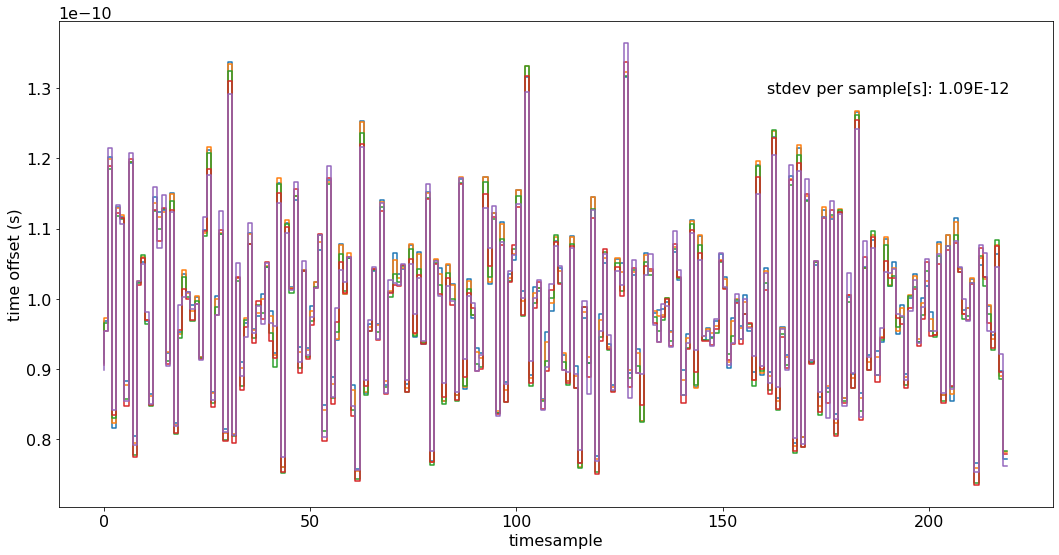

In [13]:
for ped in [6,7,8,9, 10]:
    plt.step(np.linspace(0, TRIG_POS-2, TRIG_POS-1), timeOffsetWeighted[ped])
print("total variance(s^2):")
print(np.sum(np.var(timeOffsetWeighted[6:11], axis=0)))
plt.text(190, 1.3e-10, "stdev per sample[s]: %.2E"%np.sqrt(np.sum(np.var(timeOffsetWeighted[6:11], axis=0))/TRIG_POS), horizontalalignment='center', verticalalignment='center')
plt.ylabel("time offset (s)")
plt.xlabel("timesample")
plt.tight_layout()
plt.savefig("timebase_weighted_varped.jpg", dpi=300, bbox_inches='tight')

total variance(s^2):
5.260642435434266e-21


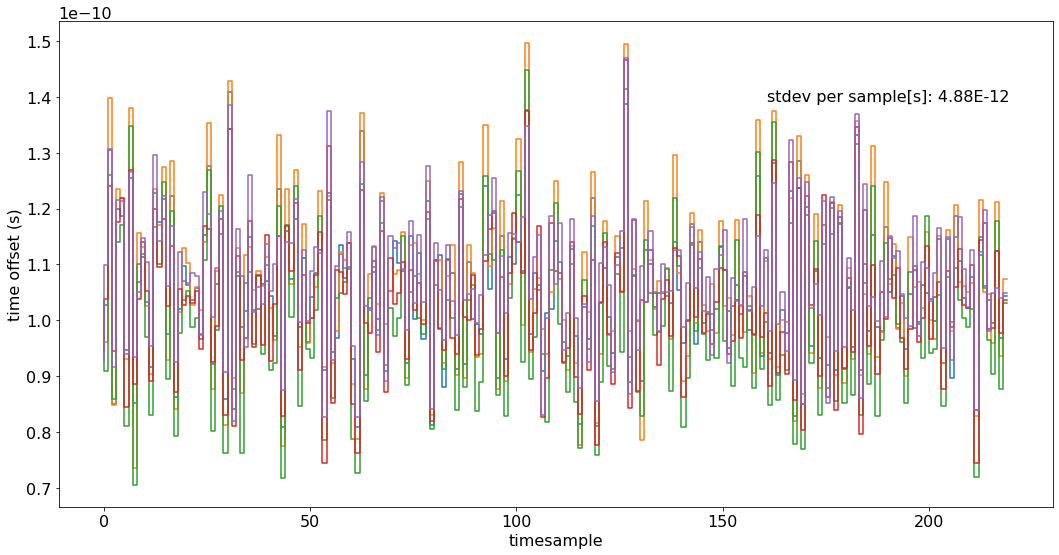

In [12]:
for ped in [6,7,8,9, 10]:
    plt.step(np.linspace(0, TRIG_POS-2, TRIG_POS-1), timeOffsetSimple[ped])
print("total variance(s^2):")
print(np.sum(np.var(timeOffsetSimple[6:11], axis=0)))
plt.text(190, 1.4e-10, "stdev per sample[s]: %.2E"%np.sqrt(np.sum(np.var(timeOffsetSimple[6:11], axis=0))/TRIG_POS), horizontalalignment='center', verticalalignment='center')
plt.ylabel("time offset (s)")
plt.xlabel("timesample")
plt.tight_layout()
plt.savefig("timebase_simple_varped.jpg", dpi=300, bbox_inches='tight')

Text(0.5, 0, 'timesample')

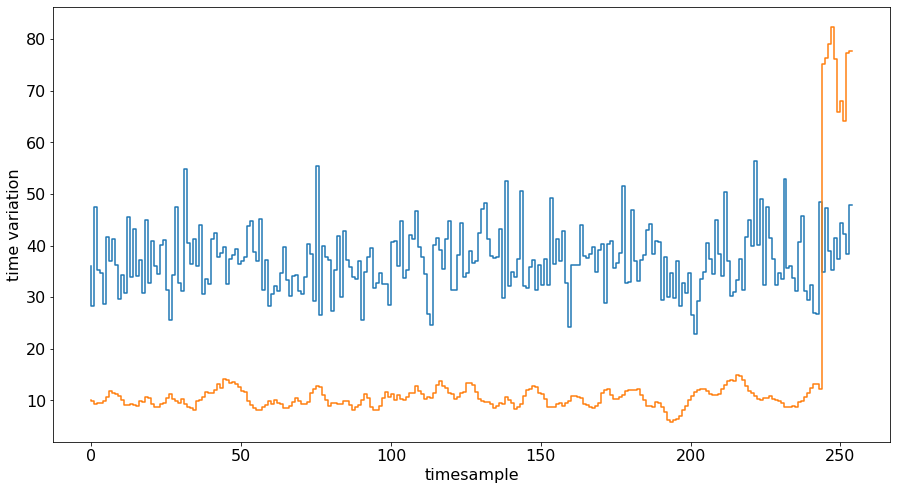

In [45]:
for diff in [1, 11]:
    plt.step(np.linspace(0, 254, 255), timeOffsetVar[diff,11, 0:255])
plt.ylabel("time variance (s^2)")
plt.xlabel("timesample")

Text(0.5, 0, 'timesample')

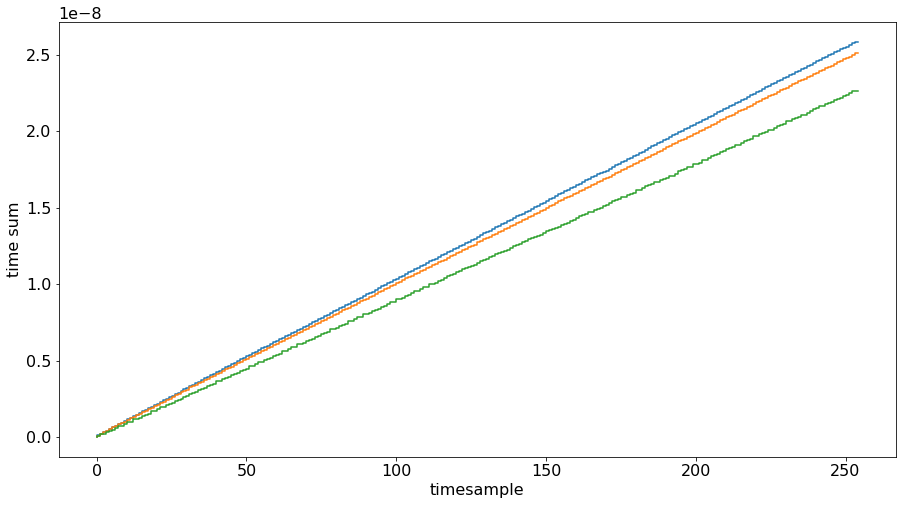

In [47]:
for diff in [1, 3, 11]:
    plt.step(np.linspace(0, 254, 255), timeOffsetSum[diff,11, 0:255])
plt.ylabel("time sum")
plt.xlabel("timesample")

In [127]:
#ydata = sineData-averages
ydata = linDat - 1.2/4096*ped_value
for channel in [11]:
    chTimeOffsetMatrix = []
    x = []
    y =[]
    phase = []
    residuals = []
    for iCap in range(256):
        
        cap1 = iCap
        cap2 = (iCap+1)%256
        r = []
        for e in range(0,1000):
           # if abs(trigger_pos[e]-cap1)<15 or (trigger_pos[e]-15<0 and 256-cap1+trigger_pos[e]<15) or (cap1-15<0 and 256-trigger_pos[e]+cap1<15):
                continue
           # else: 
                r.append(e)


        x.append(ydata[r,channel, cap2] + ydata[r,channel, cap1])
        y.append(ydata[r,channel, cap1] - ydata[r,channel, cap2])

        #y = y[(x > 1200) | (x < -1200)]
        #x = x[(x > 1200) | (x < -1200)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        #A = np.column_stack([x[iCap]**2, x[iCap] * y[iCap], y[iCap]**2, x[iCap], y[iCap]])
        #Formulate and solve the least squares problem ||Ax - b ||^2, only for right ellipse
        A = np.column_stack([x[iCap]**2, y[iCap]**2])
        b = np.ones_like(x[iCap])
        fit2 = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        phase.append(np.arctan2(y[iCap]/np.sqrt(fit2[0]), x[iCap]/np.sqrt(fit2[1])))
        residuals.append((x[iCap])**2*fit2[0]+(y[iCap])**2*fit2[1]-1)
        #print(fit)



3116


Text(0.5, 1.0, 'Triangular waveform of 20,40,60,80,120MHz, capacitor 125')

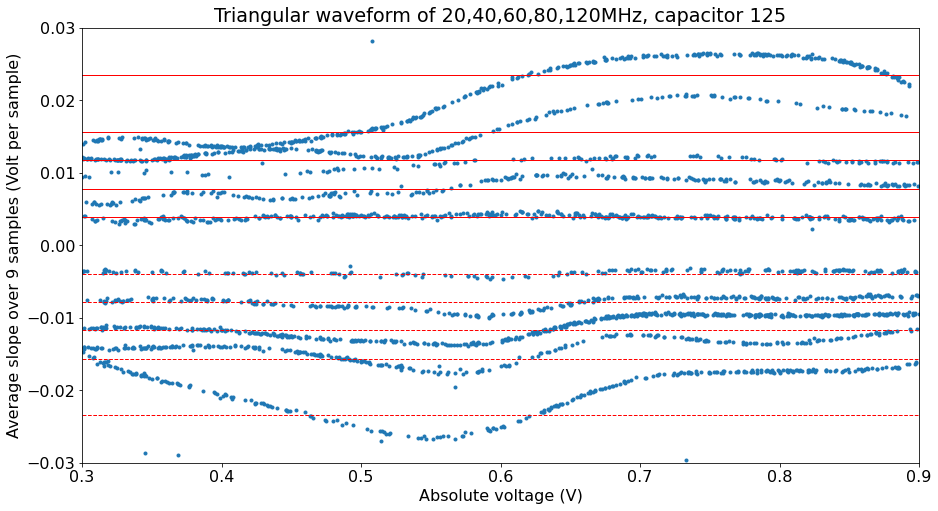

In [121]:

#plt.plot(ydata[0,:,5])
sample = 125
plt.scatter(x[sample]+0.6, y[sample], marker='.')
print(x[sample].size)

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x[sample].min()+0.6,1.05*x[sample].max()+0.6,300)
y_coord = np.linspace(1.05*y[sample].min(),1.05*y[sample].max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
#fit = coefs[sample]
#Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
Z_coord = 256*20*Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[-120,-80,-60,-40,-20,20,40,60,80,120], colors=('r'), linewidths=1)
plt.xlim(0.3, 0.9)
plt.ylim(-0.03, 0.03)
plt.ylabel("Average slope over 9 samples (Volt per sample)")
plt.xlabel("Absolute voltage (V)")
plt.title("Triangular waveform of 20,40,60,80,120MHz, capacitor "+str(sample))

In [183]:
# solve for y: fit[0] * x ** 2 + fit[1] * x * y + fit[2] * y**2 + fit[3] * x + fit[4] * y = 1
# fit[2] * y**2 + (fit[1] * x + fit[4]) * y - 1 + fit[0] * x ** 2 + fit[3] * x = 0
# (-(fit[1]*x+fit[4]) +- sqrt((fit[1]*x+fit[4])**2 - 4 * fit[2] * (fit[0] * x ** 2 + fit[3] * x-1))) / 2 * fit[2]
#find peak to determine the sign of the sqrt

f_slope_correction = []
peaks_p = []
peaks_m = []
for iCap in range(256):
    indarray = np.argsort(x[iCap])
   
    ypeak_minus = np.median(y[iCap][:indarray[nevents//100]])
    peaks_m.append(ypeak_minus)
    ypeak_plus = np.median(y[iCap][-indarray[nevents//100]:])
    peaks_p.append(ypeak_plus)
    y_fit = []
    fit = coefs[iCap]
    for i in range(x[iCap].size):
        if (x[iCap][i]<0 and y[iCap][i]<ypeak_minus) or (x[iCap][i]>0 and y[iCap][i]<ypeak_plus):
            y_fit.append((-(fit[1]*x[iCap][i]+fit[4]) - np.sqrt((fit[1]*x[iCap][i]+fit[4])**2 - 4 * fit[2] * (fit[0] * x[iCap][i] ** 2 + fit[3] * x[iCap][i]-1))) / 2 / fit[2])
        else:
            y_fit.append((-(fit[1]*x[iCap][i]+fit[4]) + np.sqrt((fit[1]*x[iCap][i]+fit[4])**2 - 4 * fit[2] * (fit[0] * x[iCap][i] ** 2 + fit[3] * x[iCap][i]-1))) / 2 / fit[2])
        if(np.isnan(y_fit[i])):
                y_fit[i] = ypeak_minus if x[iCap][i]<0 else ypeak_plus
    y_fit = np.array(y_fit)
    f_slope_correction.append(scipy.interpolate.SmoothBivariateSpline(x[iCap], y[iCap], y_fit-y[iCap], s = x[iCap].size/100000))
    #plt.scatter(x[sample], y_fit)


/tmp/ipykernel_330/232187537.py:20: RuntimeWarning: invalid value encountered in sqrt
  y_fit.append((-(fit[1]*x[iCap][i]+fit[4]) - np.sqrt((fit[1]*x[iCap][i]+fit[4])**2 - 4 * fit[2] * (fit[0] * x[iCap][i] ** 2 + fit[3] * x[iCap][i]-1))) / 2 / fit[2])
/tmp/ipykernel_330/232187537.py:22: RuntimeWarning: invalid value encountered in sqrt
  y_fit.append((-(fit[1]*x[iCap][i]+fit[4]) + np.sqrt((fit[1]*x[iCap][i]+fit[4])**2 - 4 * fit[2] * (fit[0] * x[iCap][i] ** 2 + fit[3] * x[iCap][i]-1))) / 2 / fit[2])


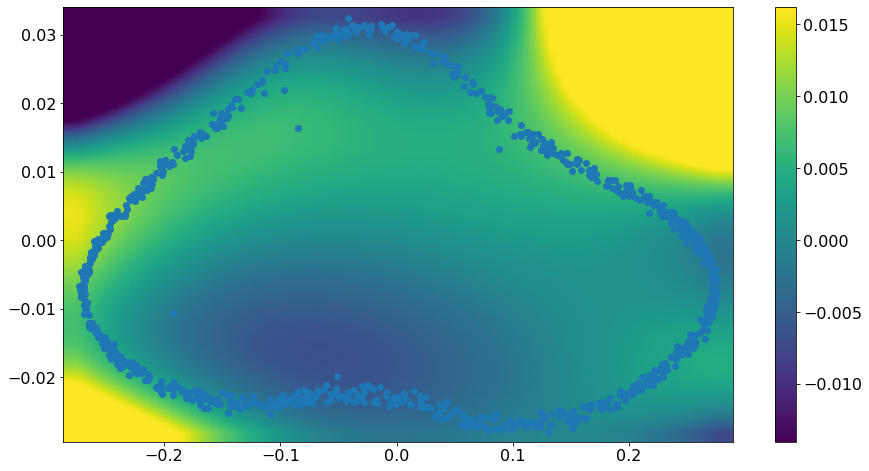

In [191]:
sample = 139
res = 100
xgrid = np.mgrid[1.05*x[sample].min():1.05*x[sample].max():100j, 1.05*y[sample].min():1.05*y[sample].max():100j]
yflat = f_slope_correction[sample](np.linspace(1.05*x[sample].min(),1.05*x[sample].max(),res), np.linspace(1.05*y[sample].min(),1.05*y[sample].max(),res))
ygrid = yflat.reshape(res, res)
fig, ax = plt.subplots()
p = ax.pcolormesh(*xgrid, ygrid, vmin=y[sample].min()*0.5, vmax=y[sample].max()*0.5, shading='gouraud')
ax.scatter(x[sample], y[sample])
fig.colorbar(p)
plt.show()


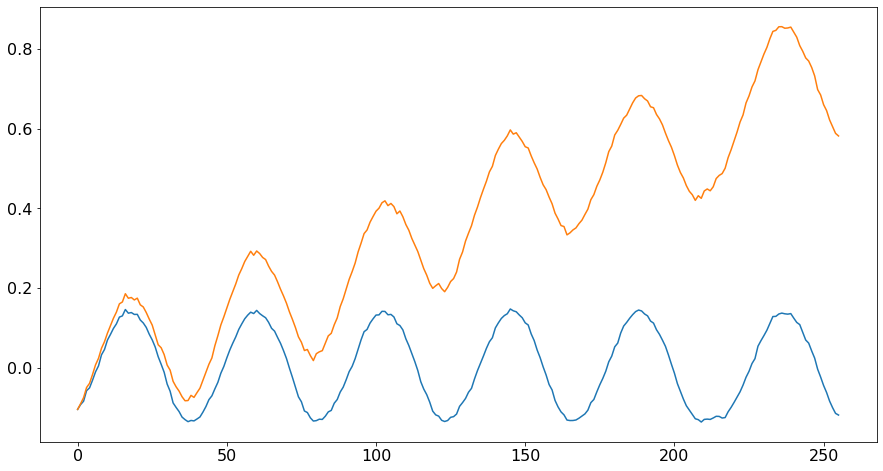

In [201]:
xdata = np.linspace(0, 255,256)
sampledata = linDat[33,11,:] - 1.2/4096*ped_value
plt.plot(xdata, sampledata)
slope_corrected_data= np.zeros_like(sampledata)
for i in range(256):
    cap0 = (i+255)%256
    cap1 = i
    cap2 = (i+1)%256
    #t1 = sampledata[cap0] + f_slope_correction[cap0](sampledata[cap0], sampledata[cap1]-sampledata[cap0])
    #t2 = sampledata[cap2] - f_slope_correction[cap1](sampledata[cap1], sampledata[cap2]-sampledata[cap1])
    t3 = slope_corrected_data[cap0] + sampledata[cap1] - sampledata[cap0] + f_slope_correction[cap0](sampledata[cap0], sampledata[cap1]-sampledata[cap0]) if i!=0 else sampledata[0]
    slope_corrected_data[cap1] = t3 #average
plt.plot(xdata, slope_corrected_data)
#print(slope_corrected_data)

In [ ]:
timeOffsets_ydot_coef = 0.0


Text(0, 0.5, 'Residuals, 0 when perfect sine wave. ')

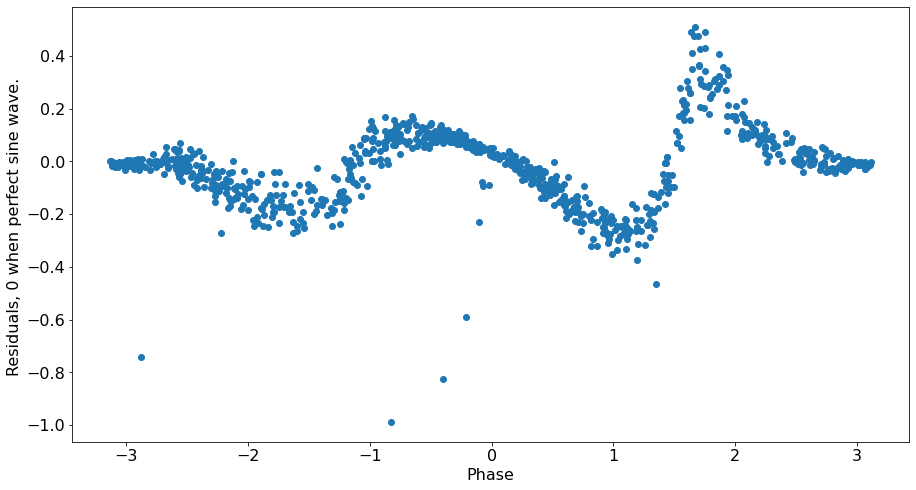

In [132]:

sample = 49
#plt.plot(ydata[0,:,5])
plt.scatter(phase[sample], residuals[sample])
plt.xlabel("Phase")
plt.ylabel("Residuals, 0 when perfect sine wave. ")


Text(0.5, 0, 'time offsets (ps)')

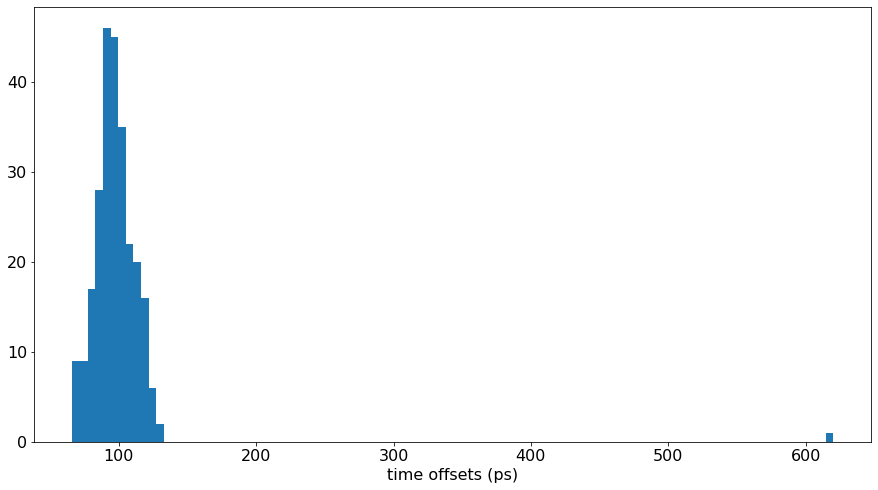

In [ ]:
plt.hist(timeOffsets[29]*1e12, 100)
plt.xlabel("time offsets (ps)")

Text(0.5, 0, 'timesample')

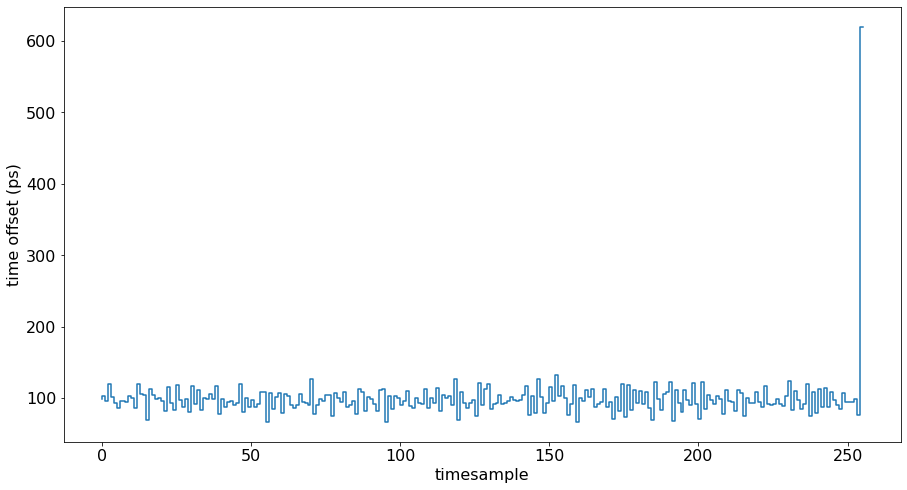

In [ ]:
plt.step(np.linspace(0, 255, 256), timeOffsets[29]*1e12)
plt.ylabel("time offset (ps)")
plt.xlabel("timesample")

In [ ]:
plt.step(np.linspace(0, 255, 256), timeOffsets[29]*1e12)
plt.ylabel("time offset (ps)")
plt.xlabel("timesample")

0.70537521876794 0.03907925869442077 1570997526.1660066 144.78334959035158


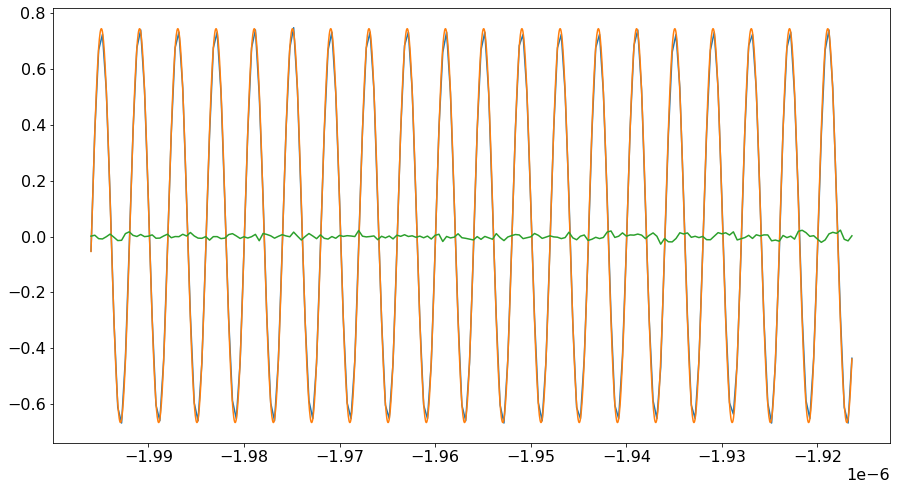

In [ ]:
x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)

popt=(0.75, 0.0, 1.50/1e-9, 0.0)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[50:60], y_tsdata[50:60], p0=popt)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[0:100], y_tsdata[0:100], p0=popt)
print(*popt)

diff = y_tsdata - sine(x_tsdata, *popt)

plt.plot(x_tsdata[:200], y_tsdata[:200])

x_sim = np.linspace(x_tsdata[:200].min(), x_tsdata[:200].max(), 2000)
plt.plot(x_sim, sine(x_sim, *popt), label="sine fit")

plt.plot(x_tsdata[:200], diff[:200])

902.2631716750004 3.592298062120782 0.14408683129245053 -5.871691599513418
mse: 0.650075


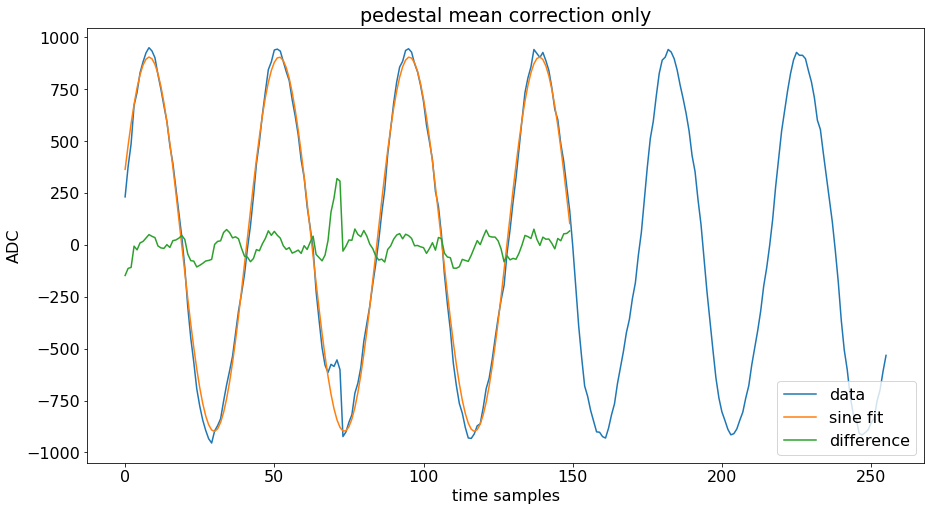

In [ ]:
from scipy import optimize
event = 5
channel = 11

xdata = np.linspace(0, 255,256)
ydata = sineData[event,channel,:]-averages[channel, :]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[:150], ydata[:150], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
pmco_diff = diff
print("mse: %f"%((diff**2)[:150].sum()))

plt.title("pedestal mean correction only")
plt.xlabel("time samples")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata[:150], sine(xdata[:150], *popt), label="sine fit")

plt.plot(xdata[:150], diff[:150]*1000, label="difference")

plt.legend(loc="lower right")

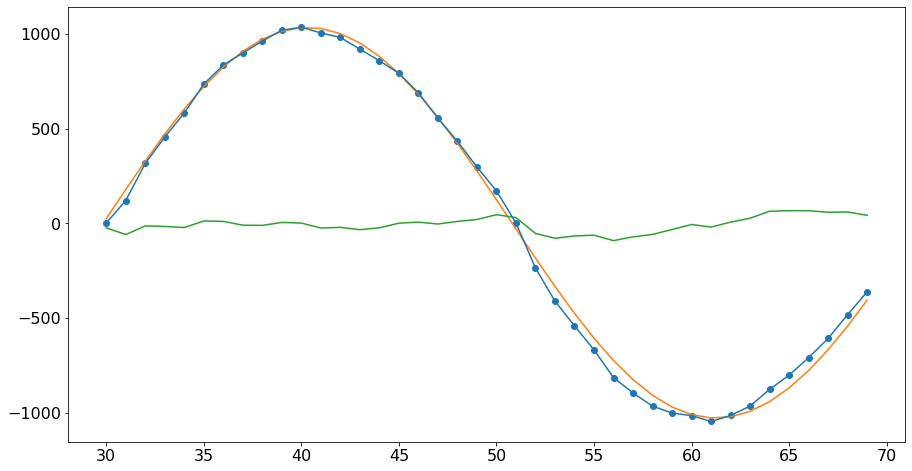

In [ ]:
plt.scatter(xdata[30:70], ydata[30:70], label="data")
plt.errorbar(xdata[30:70], ydata[30:70], yerr=3, label="data")

plt.plot(xdata[30:70], sine(xdata[30:70], *popt), label="sine fit")

plt.plot(xdata[30:70], diff[30:70]*popt[0], label="difference")

In [ ]:
xdata = np.linspace(0, 255,256)
#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, :, channel]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
vlo_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Voltage linearization only")
plt.xlabel("time samples")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

NameError: name 'linDat' is not defined

865.670238869239 -7.572048545938256 1.4863520874328442 0.17040814445800195
mse: 0.513777


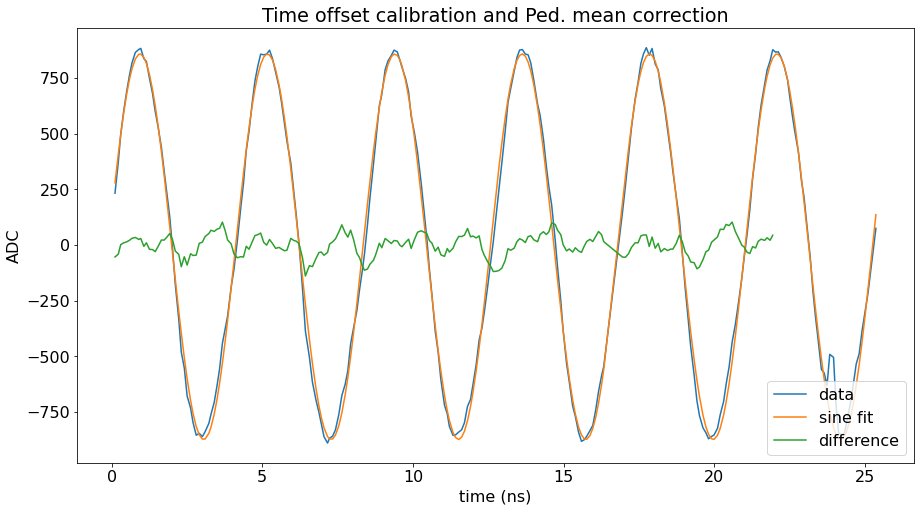

In [ ]:
event = 5
channel = 29
ringTimeOffsets = np.concatenate((timeOffsets,timeOffsets,timeOffsets), 1)
xdata = np.cumsum(ringTimeOffsets[channel, trigger_pos[event]+14:trigger_pos[event]+14+256])*1e9
ydata = sineData[event,channel,:]-averages[channel, :]
ringydata = np.concatenate((ydata,ydata,ydata))[trigger_pos[event]+15:trigger_pos[event]+15+256]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ringydata[50:100], p0=(400.0, 0.0, true_freq*math.pi*2e-9, 0.0), bounds=((200, -2000, true_freq*math.pi*2e-9*0.8, -400),(2000, 2000, true_freq*math.pi*2e-9*1.2,400)))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[:220], ringydata[:220], p0=popt)

print(*popt)

diff = (ringydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:220].sum()))

plt.title("Time offset calibration and Ped. mean correction")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ringydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:220], diff[:220]*1000, label="difference")

plt.legend(loc="lower right")

-0.23927754802618814 0.5950847190295432 1.48777167396399 0.46192105132313827
mse: 0.494389


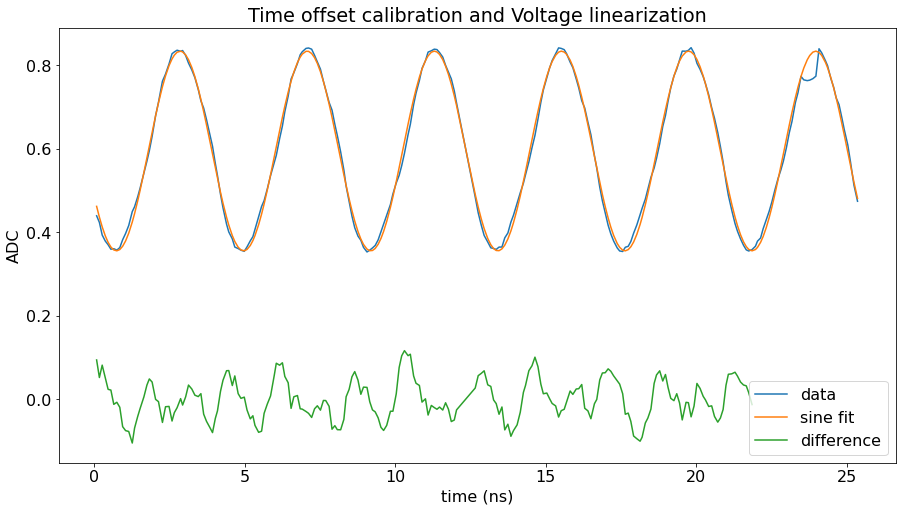

In [ ]:
event = 7
channel = 29
import scipy.optimize
ringTimeOffsets = np.concatenate((timeOffsets,timeOffsets,timeOffsets), 1)
xdata = np.cumsum(ringTimeOffsets[channel, trigger_pos[event]+14:trigger_pos[event]+14+256])*1e9
ydata = linDat[event, channel, :]
ringydata = np.concatenate((ydata,ydata,ydata))[trigger_pos[event]+15:trigger_pos[event]+15+256]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ringydata[50:100], p0=(400.0, 0.0, true_freq*math.pi*2e-9, 0.0), bounds=((200, -2000, true_freq*math.pi*2e-9*0.8, -400),(2000, 2000, true_freq*math.pi*2e-9*1.2,400)))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[:220], ringydata[:220], p0=popt)

print(*popt)

diff = (ringydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:220].sum()))

plt.title("Time offset calibration and Voltage linearization")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ringydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:220], diff[:220], label="difference")

plt.legend(loc="lower right")

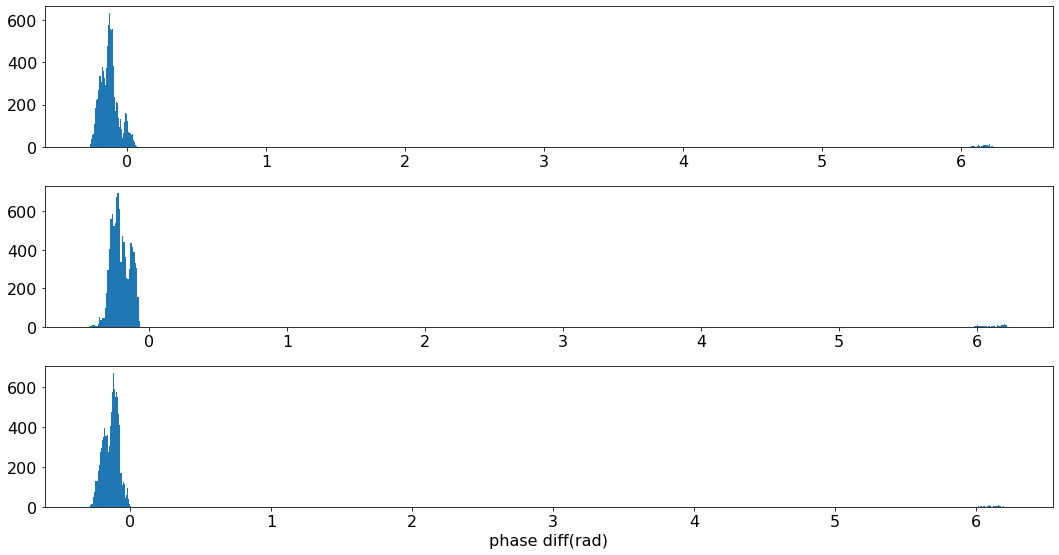

In [ ]:
phase = np.zeros((10000, 30))
for event in range(10000):
    for channel in [11, 17, 23,29]:
        xdata = np.cumsum(ringTimeOffsets[channel, trigger_pos[event]+14:trigger_pos[event]+14+256])*1e9
        ydata = sineData[event,channel,:]-averages[channel, :]
        ringydata = np.concatenate((ydata,ydata,ydata))[trigger_pos[event]+15:trigger_pos[event]+15+256]
        #ydata = linDat[event, :, 5]

        popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ringydata[50:100], p0=(400.0, 0.0, true_freq*math.pi*2e-9, 0.0), bounds=((200, -2000, true_freq*math.pi*2e-9*0.8, -4),(2000, 2000, true_freq*math.pi*2e-9*1.2,4)))
        popt, pcov = scipy.optimize.curve_fit(sine, xdata[:220], ringydata[:220], p0=popt)
        phase[event, channel] = popt[3]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.hist(wrap(phase[:,17] - phase[:,11]), bins="fd")
ax2.hist(wrap(phase[:,23] - phase[:,11]), bins="fd")
ax3.hist(wrap(phase[:,29] - phase[:,11]), bins="fd")#/true_freq/math.pi/2e-9
plt.xlabel("phase diff(rad)")
fig.tight_layout()
    

0.30721129658631996 0.5994629531264452 1.5745048426530697 -11.001931054749994
mse: 0.348352


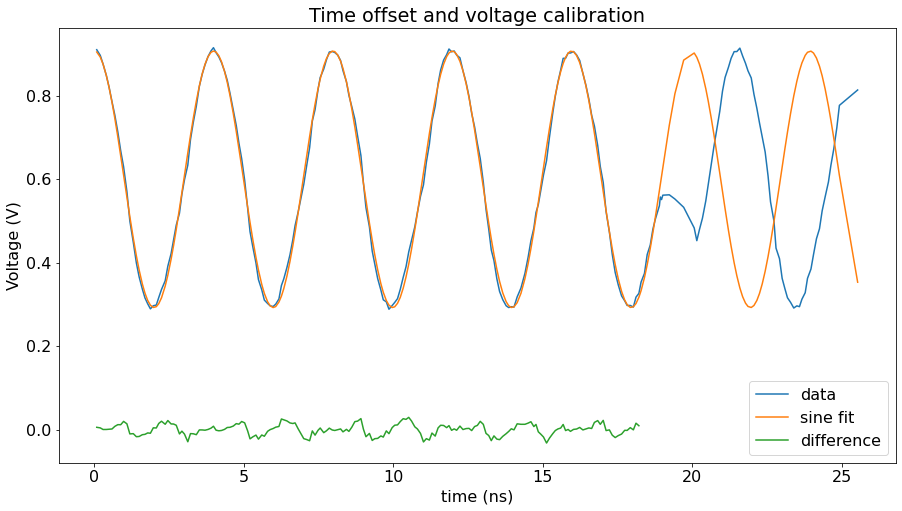

In [ ]:

#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, channel, :]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/5000, 0.6))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/np.abs(popt[0])
all_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset and voltage calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

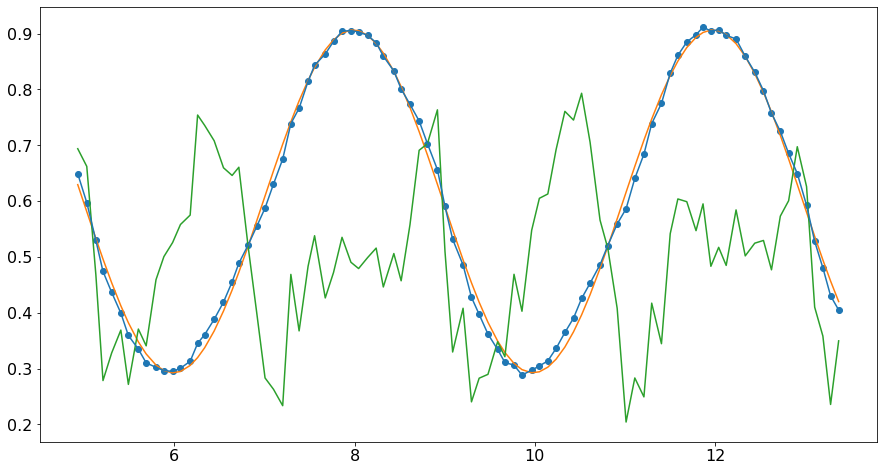

In [ ]:
t = 20
s = slice(30+t,120+t)

plt.scatter(xdata[s], ydata[s], label="data")
plt.errorbar(xdata[s], ydata[s], yerr=3*1.2/4096, label="data")

plt.plot(xdata[s], sine(xdata[s], *popt), label="sine fit")

plt.plot(xdata[s], diff[s]*popt[0]*10 + 0.5, label="difference")

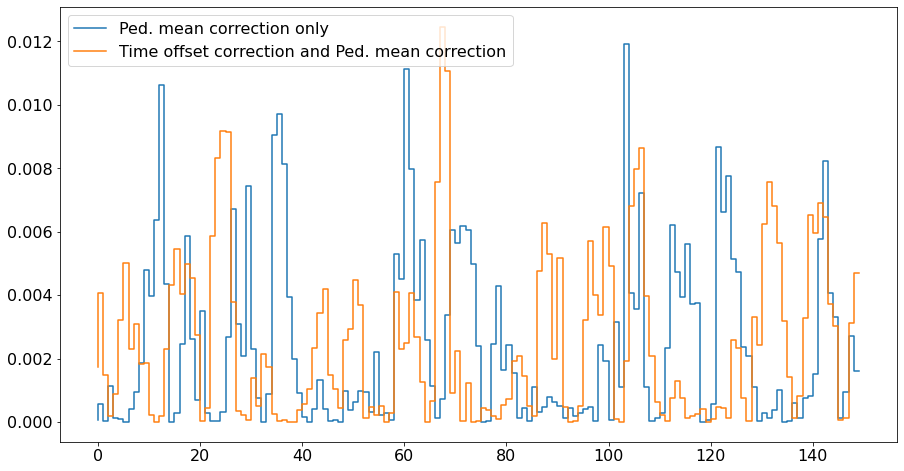

In [ ]:
xdat = np.linspace(0, 149, 150)
plt.step(xdat,pmco_diff[:150]**2, label="Ped. mean correction only")
#plt.step(xdat,vlo_diff[:190]**2, label="Voltage linearization only")
plt.step(xdat,toco_diff[:150]**2, label="Time offset correction and Ped. mean correction")
#plt.step(xdat,all_diff[:190]**2, label="All corrections")
plt.legend()

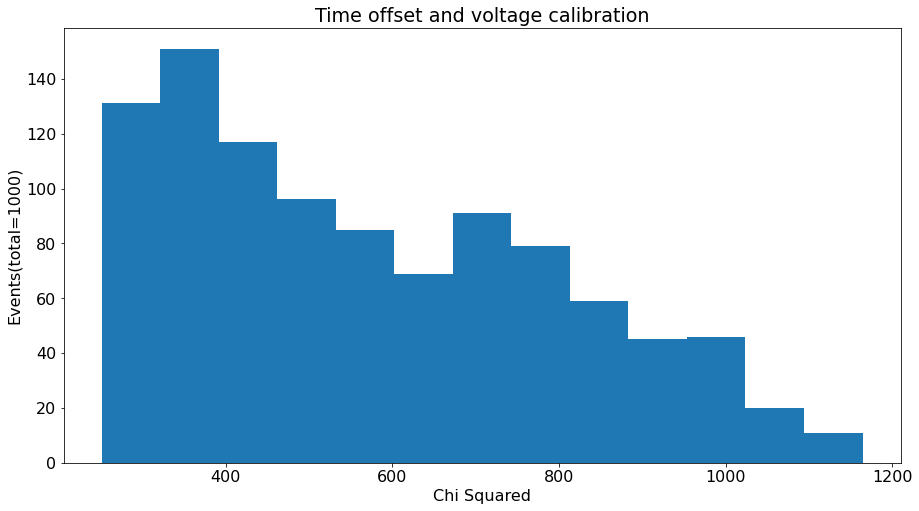

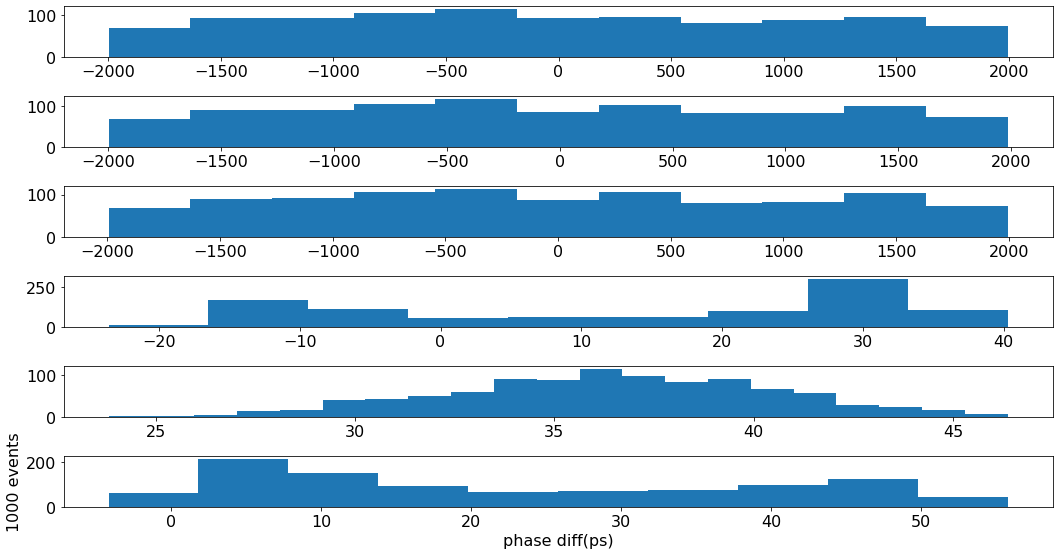

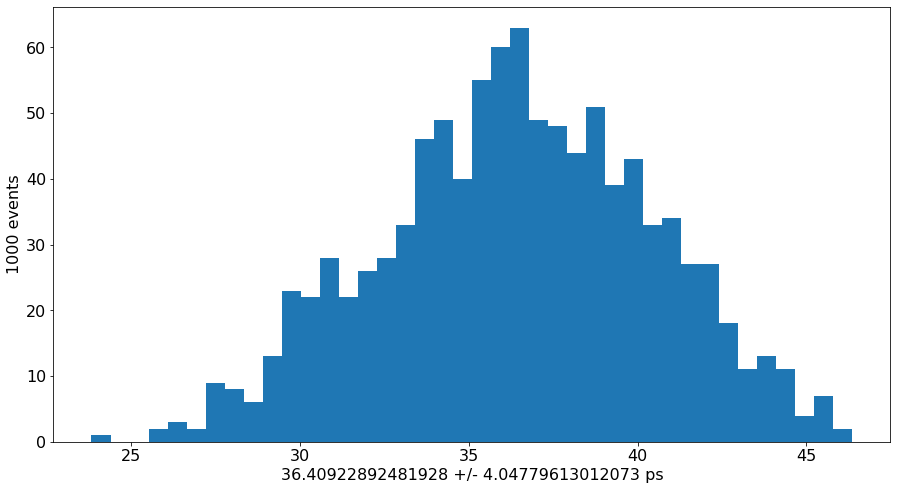

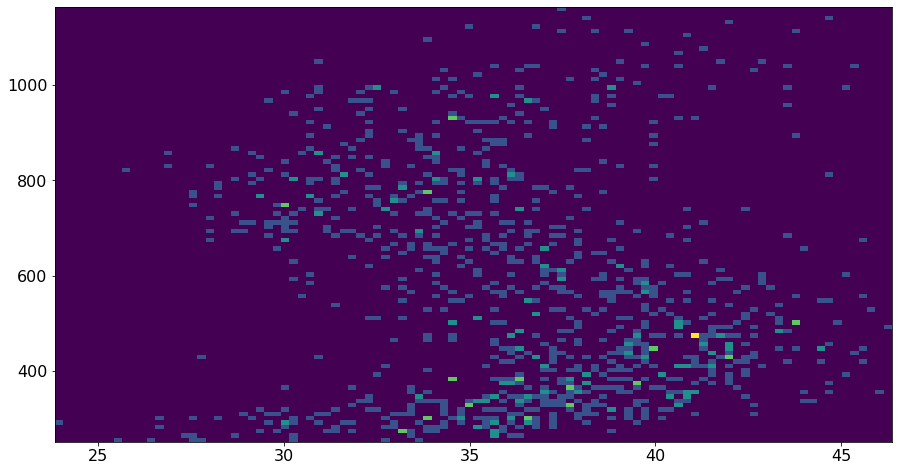

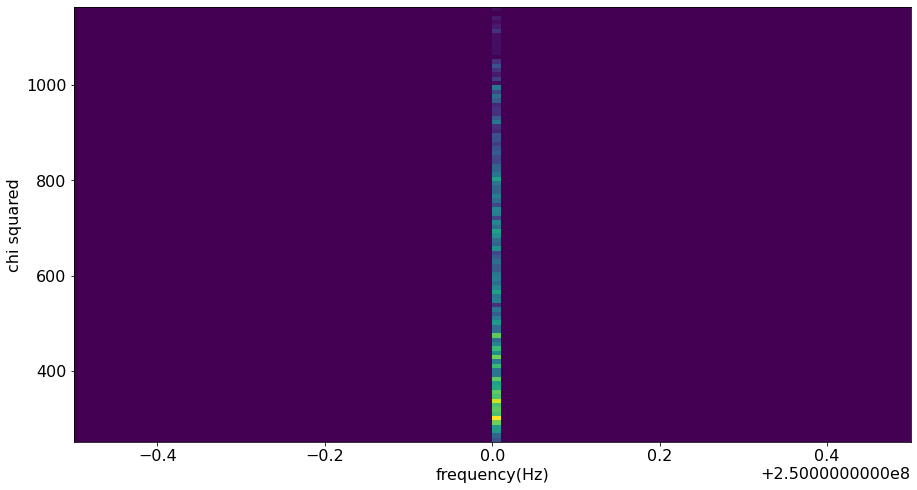

In [72]:
#Phase Jitter calculation when trigger point is fixed.
import scipy.optimize
ped = 8

phase = np.zeros((nevents, 30))
freq = np.zeros((nevents, 30))
chi = []
for event in range(nevents):
    chi.append(0)
    xdataList = np.zeros((30, TRIG_POS-1))
    ydataList = np.zeros((30, TRIG_POS-1))
    sineCurve = np.zeros((30, TRIG_POS-1))
    for channel in [11, 17, 23,29]:
        xdata = np.cumsum(timeOffsetWeighted[channel, ped])
        ydata = linDat[(ped-6)*1000+event, channel, 0:(TRIG_POS-1)] - 1.2/16*ped
        popt, pcov = scipy.optimize.curve_fit(lambda x,a,b,phi: sine(x,a,b,2*math.pi*true_freq, phi), xdata[0:20], ydata[0:20], p0=(0.5, 0.0, 0.0), bounds=((0.1, -0.05, -4),(1, 0.05,4)))
        popt, pcov = scipy.optimize.curve_fit(lambda x,a,b,phi: sine(x,a,b,2*math.pi*true_freq, phi), xdata, ydata, p0=popt, bounds=((0.1, -0.05, -4),(1, 0.05,4)))
        diff = (ydata - sine(xdata, popt[0],popt[1],2*math.pi*true_freq,popt[2]))/7e-4#np.abs(popt[0])
        chi[event]+=(diff**2).mean()/4
        phase[event, channel] = popt[2]
        freq[event, channel] = true_freq #popt[1]/2/math.pi
        xdataList[channel, :] = xdata
        ydataList[channel, :] = ydata
        sineCurve[channel, :] = sine(xdata, popt[0],popt[1],2*math.pi*true_freq,popt[2])
plt.title("Time offset and voltage calibration")
plt.xlabel("Chi Squared")
plt.ylabel("Events(total="+str(nevents)+")")
plt.hist(chi, bins="fd")
plt.show()

phase2 = np.array([phase[x, :] for x in range(nevents) if chi[x] < 55000]) #remove events that are too close to the wraparound.
#if trigger_pos[x] < 120

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.hist(wrap(phase2[:,17])/true_freq/math.pi/2e-12, bins="fd")
ax2.hist(wrap(phase2[:,23])/true_freq/math.pi/2e-12, bins="fd")
ax3.hist(wrap(phase2[:,29])/true_freq/math.pi/2e-12, bins="fd")
ax4.hist(wrap(phase2[:,23] - phase2[:,17])/true_freq/math.pi/2e-12, bins="fd")
ax5.hist(wrap(phase2[:,29] - phase2[:,17])/true_freq/math.pi/2e-12, bins="fd")
ax6.hist(wrap(phase2[:,29] - phase2[:,23])/true_freq/math.pi/2e-12, bins="fd")

plt.xlabel("phase diff(ps)")
plt.ylabel(str(len(phase2))+" events")
fig.tight_layout()
plt.show()
plt.savefig("phasejitter_weighted_nocutoff_1.jpg", dpi=300, bbox_inches='tight')
plt.hist(wrap(phase2[:,29] - phase2[:,17])/true_freq/math.pi/2e-12, bins=40)
mean = np.mean(wrap(phase2[:,29] - phase2[:,17])/true_freq/math.pi/2e-12)
std = np.std(wrap(phase2[:,29] - phase2[:,17])/true_freq/math.pi/2e-12)
plt.xlabel(str(mean)+" +/- "+str(std)+" ps")
plt.ylabel(str(len(phase2))+" events")
plt.show()
plt.savefig("phasejitter_weighted_nocutoff_2.jpg", dpi=300, bbox_inches='tight')
heatmap, xedges, yedges = np.histogram2d(wrap(phase[:,29] - phase[:,17])/true_freq/math.pi/2e-12, chi, bins=100)
plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower", aspect="auto")
plt.show()
plt.savefig("phasejitter_weighted_nocutoff_3.jpg", dpi=300, bbox_inches='tight')
heatmap, xedges, yedges = np.histogram2d(np.average(freq, 1)*7.5, chi, bins=100)
plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower", aspect="auto")
plt.xlabel("frequency(Hz)")
plt.ylabel("chi squared")
plt.show()